In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

from mod_moving_mnist import ModMovingMNIST
from mpnnlstm import NextFramePredictor

from utils import normalize

/Users/zach/opt/miniconda3/envs/mpnnlstm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Number of frames to read as input
input_timesteps = 4
output_timesteps= 4

# Create a dataset using the modified MovingMNIST
MMMNIST = ModMovingMNIST(
    canvas_size=(16, 16),
    digit_size=(6, 6),
    pixel_noise=0.05,
    velocity_noise=0.0,
)

# Create a train set (500), test set (50), and validation set (50)
x, y = MMMNIST.create_dataset(100, input_timesteps, output_timesteps, n_digits=1)
x_test, y_test = MMMNIST.create_dataset(50, input_timesteps, output_timesteps, n_digits=1)
x_val, y_val = MMMNIST.create_dataset(50, input_timesteps, output_timesteps, n_digits=1)

y, y_test, y_val = y[:, ::-1].copy(), y_test[:, ::-1].copy(), y_val[:, ::-1].copy()

# x, y = normalize(x), normalize(y)
# x_test, y_test = normalize(x_test), normalize(y_test)
# x_val, y_val = normalize(x), normalize(y)

In [3]:
from mpnnlstm import NextFramePredictor
from seq2seq import Seq2Seq

from torch.optim.lr_scheduler import StepLR
import time
import pandas as pd
from tqdm import tqdm

from graph_functions import image_to_graph, flatten, create_graph_structure, unflatten
from utils import add_positional_encoding

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NextFramePredictorSeq2Seq(NextFramePredictor):
    def __init__(self, 
                 experiment_name='reduced', 
                 decompose=True, 
                 input_features=1,
                 multi_step_loss=1, 
                 output_timesteps=3,
                 integrated_space_time=True,
                 device=device,
                 **model_kwargs):
        
        super().__init__(
                 experiment_name='reduced', 
                 decompose=True, 
                 input_features=1,
                 multi_step_loss=1, 
                 integrated_space_time=True,
                 device=device,
                 **model_kwargs)
        
        self.output_timesteps = output_timesteps
        

        # Add 3 to the number of input features since we add positional encoding (x, y) and node size (s)
        self.model = Seq2Seq(input_features=input_features+3, output_timesteps=output_timesteps, **model_kwargs).float()


    def train(
        self,
        x,
        y,
        x_test,
        y_test,
        n_epochs=200,
        lr=0.01,
        lr_decay=0.95,
        ):

        if self.thresh is None:
            raise ValueError('Please set the threshold using set_thresh(thresh)!')

        image_shape = x[0].shape[1:-1]

        x = add_positional_encoding(x, self.model.input_timesteps)
        x_test = add_positional_encoding(x_test, self.model.input_timesteps)

        # Add 2 to the number of features since we add positional encoding (x, y)
        # x_graph = [image_to_graph(img, num_features=self.input_features+2, thresh=self.thresh) for img in x]
        # x_test_graph = [image_to_graph(img, num_features=self.input_features+2, thresh=self.thresh) for img in x_test]
            
        self.model.to(device)
        self.model.train()

        # loss_func = torch.nn.MSELoss()
        loss_func = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        scheduler = StepLR(optimizer, step_size=10, gamma=lr_decay)

        test_loss = []
        train_loss = []

        st = time.time()
        for epoch in range(n_epochs): 
            running_loss = 0
            step = 0
            for i in tqdm(range(len(x)), leave=False):

                x_batch_img = x[i]  # 2D images (num_timesteps, x, y)
                y_batch_img = y[i]

                x_graph = image_to_graph(x_batch_img, num_features=self.input_features+2, thresh=self.thresh)

                # Create a PyG graph object
                graph = create_graph_structure(x_graph['graph_nodes'], x_graph['distances'])

                x_batch = x_graph['data']  # Image in graph format
                # y_batch, _, _ = flatten(y_batch_img, x_graph['labels'], num_features=1)
                
                # Turn target frame into graph using the graph structure from the input frames
                # y_batch, _, _ = flatten(y[i], x_graph['labels'], num_features=1)


                graph.x = torch.from_numpy(x_batch).float()
                graph.y = torch.from_numpy(y_batch_img).float()

                graph.to(device)

                optimizer.zero_grad()
                
                skip = graph.x[-1, :, [0]]  # 0th index variable is the variable of interest

                y_hat, y_hat_graph = self.model(graph.x, graph.y, x_graph, skip, image_shape, thresh=self.thresh, teacher_forcing_ratio=0.5)
                
                y_true = [torch.Tensor(flatten(np.expand_dims(y_batch_img[i], 0), y_hat_graph[i]['labels'], num_features=1)[0])[0] for i in range(self.output_timesteps)]
                
                y_hat = torch.cat(y_hat, dim=0)
                y_true = torch.cat(y_true, dim=0)
                loss = loss_func(y_hat, y_true)

                loss.backward()
                optimizer.step()

                step += 1
                running_loss += loss


            running_loss_test = 0
            step_test = 0
            for i in range(len(x_test)):

                x_batch_test_img = x_test[i]  # 2D images (num_timesteps, x, y)
                y_batch_img = y_test[i]

                x_test_graph = image_to_graph(x_batch_test_img, num_features=self.input_features+2, thresh=self.thresh)

                graph = create_graph_structure(x_test_graph['graph_nodes'], x_test_graph['distances'])

                x_batch = x_test_graph['data']
                
                
                graph.x = torch.from_numpy(x_batch).float()
                graph.y = torch.from_numpy(y_batch_img).float()

                graph.to(device)

                skip = graph.x[-1, :, [0]]  # 0th index variable is the variable of interest
                
                y_hat, y_hat_graph = self.model(graph.x, graph.y, x_test_graph, skip, image_shape, thresh=self.thresh, teacher_forcing_ratio=0.5)
                
                y_true = [torch.Tensor(flatten(np.expand_dims(y_batch_img[i], 0), y_hat_graph[i]['labels'], num_features=1)[0])[0] for i in range(self.output_timesteps)]
                
                y_hat = torch.cat(y_hat, dim=0)
                y_true = torch.cat(y_true, dim=0)
                
                loss = loss_func(y_hat, y_true)

                step_test += 1
                running_loss_test += loss


            running_loss = running_loss / (step + 1)
            running_loss_test = running_loss_test / (step_test + 1)

            scheduler.step()

            train_loss.append(running_loss.item())
            test_loss.append(running_loss_test.item())
            
            print(f"Epoch {epoch} train MSE: {running_loss.item():.4f}, "+ \
                f"test MSE: {running_loss_test.item():.4f}, lr: {scheduler.get_last_lr()[0]:.4f}, time_per_epoch: {(time.time() - st) / (epoch+1):.1f}")
        
        print(f'Finished in {(time.time() - st)/60} minutes')

        self.loss = pd.DataFrame({
            'train_loss': train_loss,
            'test_loss': test_loss,

        })
        
    def predict(self, x):

        if self.thresh is None:
            raise ValueError('Please set the threshold using set_thresh(thresh)!')

        image_shape = x[0].shape[1:-1]

        x = add_positional_encoding(x, self.model.input_timesteps)
            
        self.model.to(device)
        
        y_pred = []


        for i in tqdm(range(len(x)), leave=False):

            x_batch_img = x[i]  # 2D images (num_timesteps, x, y)

            x_graph = image_to_graph(x_batch_img, num_features=self.input_features+2, thresh=self.thresh)

            # Create a PyG graph object
            graph = create_graph_structure(x_graph['graph_nodes'], x_graph['distances'])

            x_batch = x_graph['data']  # Image in graph format

            graph.x = torch.from_numpy(x_batch).float()

            graph.to(device)
            
            skip = graph.x[-1, :, [0]]  # 0th index variable is the variable of interest

            y_hat, y_hat_graph = self.model(graph.x, None, x_graph, skip, image_shape, thresh=self.thresh, teacher_forcing_ratio=0)
            y_hat_img = [unflatten(np.expand_dims(y_hat[i].detach(), 0), y_hat_graph[i]['graph_nodes'], y_hat_graph[i]['mappings'], image_shape=image_shape) for i in range(self.output_timesteps)]
            
            y_pred.append(y_hat_img)
            
        return np.array(y_pred)




model_kwargs = dict(
    hidden_size=256,
    dropout=0.1,
    # multi_step_loss=3,
    input_timesteps=4,
    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NextFramePredictorSeq2Seq(experiment_name='test',
                                  decompose=True,
                                  input_features=1,
                                  integrated_space_time=True,
                                  device=device,
                                  output_timesteps=output_timesteps, 
                                  **model_kwargs)
model.get_n_params()

model.set_thresh(-np.inf)
# model.set_thresh(-2)
# model.set_thresh(0.5)

model.train(x, y, x_test, y_test, lr=0.001, n_epochs=25)

Epoch 0 train MSE: 0.4376, test MSE: 0.3900, lr: 0.0010, time_per_epoch: 11.5


Epoch 1 train MSE: 0.3771, test MSE: 0.3647, lr: 0.0010, time_per_epoch: 11.4


Epoch 2 train MSE: 0.3688, test MSE: 0.3552, lr: 0.0010, time_per_epoch: 12.8


Epoch 3 train MSE: 0.3554, test MSE: 0.3488, lr: 0.0010, time_per_epoch: 13.3


Epoch 4 train MSE: 0.3464, test MSE: 0.3411, lr: 0.0010, time_per_epoch: 13.7


Epoch 5 train MSE: 0.3476, test MSE: 0.3479, lr: 0.0010, time_per_epoch: 14.1


Epoch 6 train MSE: 0.3404, test MSE: 0.3410, lr: 0.0010, time_per_epoch: 14.4


Epoch 7 train MSE: 0.3410, test MSE: 0.3242, lr: 0.0010, time_per_epoch: 14.6


Epoch 8 train MSE: 0.3362, test MSE: 0.3262, lr: 0.0010, time_per_epoch: 14.9


Epoch 9 train MSE: 0.3325, test MSE: 0.3280, lr: 0.0009, time_per_epoch: 15.1


Epoch 10 train MSE: 0.3219, test MSE: 0.3394, lr: 0.0009, time_per_epoch: 15.1


Epoch 11 train MSE: 0.3261, test MSE: 0.3171, lr: 0.0009, time_per_epoch: 15.3


Epoch 12 train MSE: 0.3227, test MSE: 0.3313, lr: 0.0009, time_per_epoch: 15.3


Epoch 13 train MSE: 0.3191, test MSE: 0.3133, lr: 0.0009, time_per_epoch: 15.5


Epoch 14 train MSE: 0.3131, test MSE: 0.3267, lr: 0.0009, time_per_epoch: 15.6


Epoch 15 train MSE: 0.3179, test MSE: 0.3211, lr: 0.0009, time_per_epoch: 15.6


Epoch 16 train MSE: 0.3180, test MSE: 0.3181, lr: 0.0009, time_per_epoch: 15.6


Epoch 17 train MSE: 0.3165, test MSE: 0.3075, lr: 0.0009, time_per_epoch: 15.6


Epoch 18 train MSE: 0.3187, test MSE: 0.3098, lr: 0.0009, time_per_epoch: 15.6


Epoch 19 train MSE: 0.3151, test MSE: 0.3072, lr: 0.0009, time_per_epoch: 15.6


Epoch 20 train MSE: 0.3103, test MSE: 0.2981, lr: 0.0009, time_per_epoch: 15.6


Epoch 21 train MSE: 0.3070, test MSE: 0.3220, lr: 0.0009, time_per_epoch: 15.5


Epoch 22 train MSE: 0.3146, test MSE: 0.3162, lr: 0.0009, time_per_epoch: 15.5


Epoch 23 train MSE: 0.3031, test MSE: 0.3135, lr: 0.0009, time_per_epoch: 15.4


Epoch 24 train MSE: 0.3053, test MSE: 0.3064, lr: 0.0009, time_per_epoch: 15.4
Finished in 6.413673329353332 minutes


In [6]:
model.train(x, y, x_test, y_test, lr=0.001, n_epochs=25)

Epoch 0 train MSE: 0.3133, test MSE: 0.2919, lr: 0.0010, time_per_epoch: 12.2


Epoch 1 train MSE: 0.3112, test MSE: 0.2993, lr: 0.0010, time_per_epoch: 12.5


Epoch 2 train MSE: 0.3043, test MSE: 0.2982, lr: 0.0010, time_per_epoch: 13.0


Epoch 3 train MSE: 0.3138, test MSE: 0.2912, lr: 0.0010, time_per_epoch: 13.1


Epoch 4 train MSE: 0.2959, test MSE: 0.2974, lr: 0.0010, time_per_epoch: 13.5


Epoch 5 train MSE: 0.3036, test MSE: 0.2999, lr: 0.0010, time_per_epoch: 13.9


Epoch 6 train MSE: 0.2932, test MSE: 0.2955, lr: 0.0010, time_per_epoch: 14.2


Epoch 7 train MSE: 0.2913, test MSE: 0.2890, lr: 0.0010, time_per_epoch: 14.4


Epoch 8 train MSE: 0.2947, test MSE: 0.3038, lr: 0.0010, time_per_epoch: 14.5


Epoch 9 train MSE: 0.3016, test MSE: 0.2838, lr: 0.0009, time_per_epoch: 14.5


Epoch 10 train MSE: 0.2978, test MSE: 0.2932, lr: 0.0009, time_per_epoch: 14.5


Epoch 11 train MSE: 0.2944, test MSE: 0.2812, lr: 0.0009, time_per_epoch: 14.6


Epoch 12 train MSE: 0.2929, test MSE: 0.2748, lr: 0.0009, time_per_epoch: 14.7


Epoch 13 train MSE: 0.2964, test MSE: 0.2904, lr: 0.0009, time_per_epoch: 14.8


Epoch 14 train MSE: 0.3014, test MSE: 0.2988, lr: 0.0009, time_per_epoch: 14.9


Epoch 15 train MSE: 0.3002, test MSE: 0.2850, lr: 0.0009, time_per_epoch: 15.0


Epoch 16 train MSE: 0.2970, test MSE: 0.2888, lr: 0.0009, time_per_epoch: 15.0


Epoch 17 train MSE: 0.2880, test MSE: 0.2921, lr: 0.0009, time_per_epoch: 15.0


Epoch 18 train MSE: 0.2845, test MSE: 0.2820, lr: 0.0009, time_per_epoch: 15.0


Epoch 19 train MSE: 0.2818, test MSE: 0.2987, lr: 0.0009, time_per_epoch: 15.1


Epoch 20 train MSE: 0.2861, test MSE: 0.2916, lr: 0.0009, time_per_epoch: 15.1


Epoch 21 train MSE: 0.2987, test MSE: 0.2989, lr: 0.0009, time_per_epoch: 15.1


Epoch 22 train MSE: 0.2891, test MSE: 0.2952, lr: 0.0009, time_per_epoch: 15.1


Epoch 23 train MSE: 0.2915, test MSE: 0.2984, lr: 0.0009, time_per_epoch: 15.1


Epoch 24 train MSE: 0.2898, test MSE: 0.2842, lr: 0.0009, time_per_epoch: 15.2
Finished in 6.346228651205698 minutes


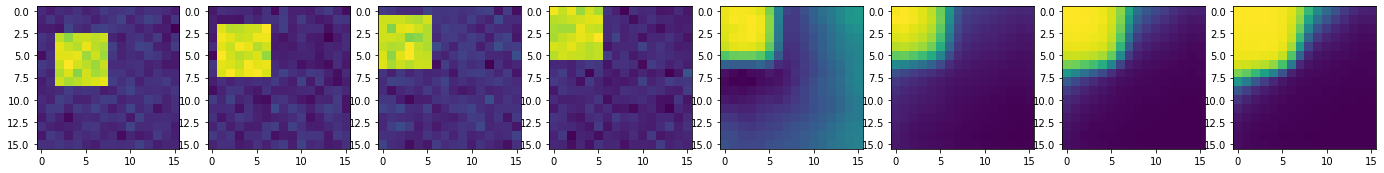

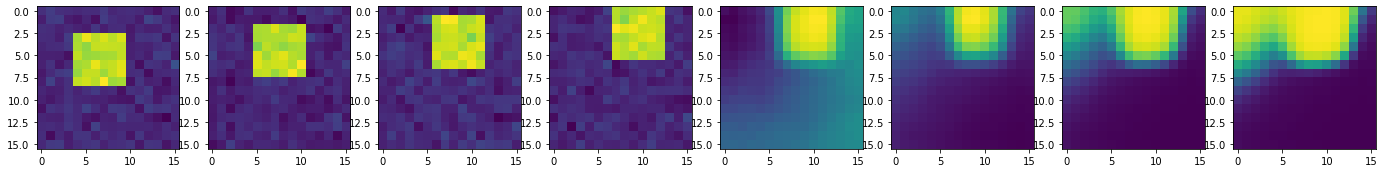

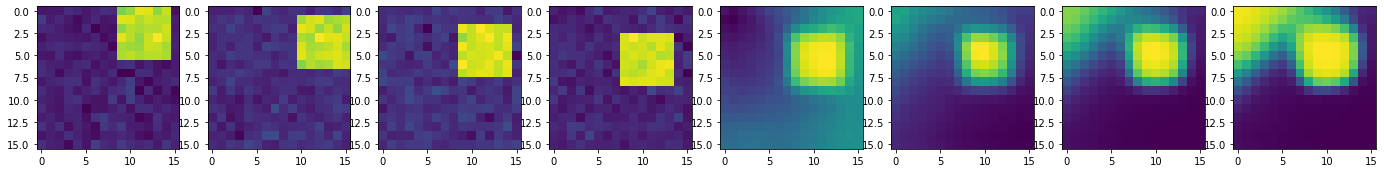

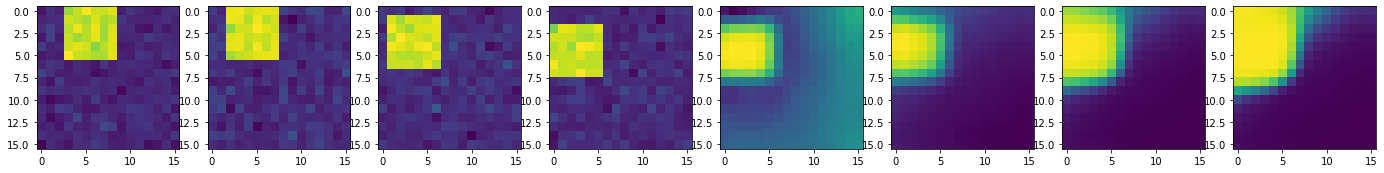

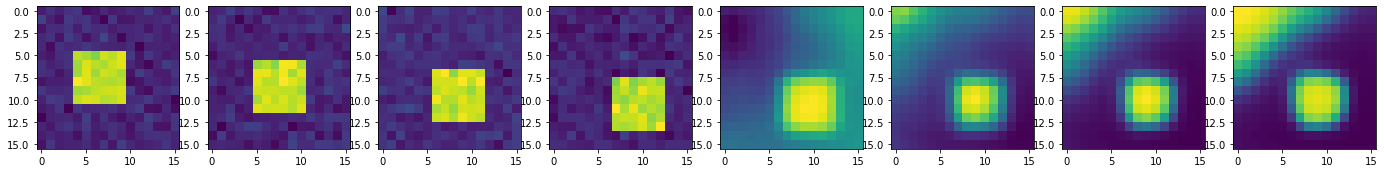

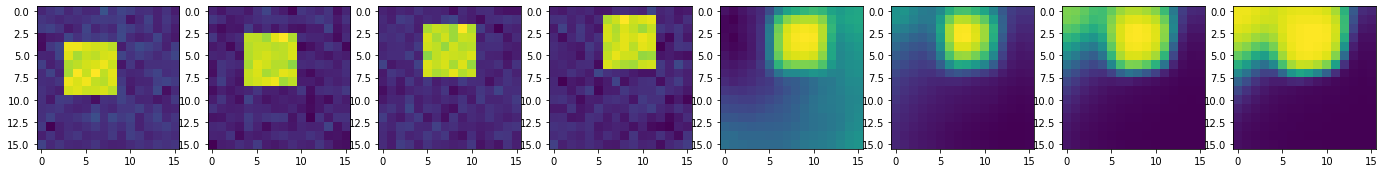

In [7]:
# Plot some example 
num_frames = 6

y_hat = model.predict(x_val[:num_frames])

for i in range(num_frames):
    fig, axs = plt.subplots(1, input_timesteps+output_timesteps, figsize=(3*(input_timesteps+output_timesteps), 4))
    
    # Inputs
    for j in range(input_timesteps):
        axs[j].imshow(x_val[i][j, ..., 0])
    
    for j in range(output_timesteps):
        axs[input_timesteps+j].imshow(y_hat[i][j][0, ..., 0])#, vmin=0, vmax=1)  # Prediction

<AxesSubplot: >

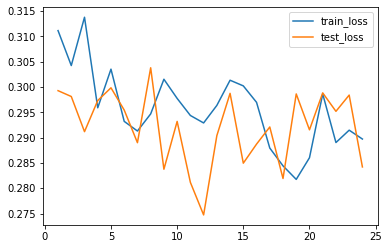

In [8]:
model.loss.iloc[1:].plot()